In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
cities = open("cities.txt", "r").read().splitlines()

In [4]:
chars = sorted(list(set("".join(cities))))
stoi = {s:i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i : s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
block_size = 3
def build_dataset(cities):
    X, Y = [], []
    for city in cities:
        context = [0] * block_size
        for ch in city + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(cities)

n1 = int(.8 * len(cities))
n2 = int(.9 * len(cities))
n1, n2

Xtr, Ytr = build_dataset(cities[:n1])
Xdev, Ydev = build_dataset(cities[n1:n2])
Xte, Yte = build_dataset(cities[n2:])

In [6]:
n_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
fan_in = n_embd * block_size

g = torch.Generator().manual_seed(23456)
C = torch.randn((vocab_size, n_embd),            generator=g) # lookup table-ish
W1 = torch.randn((n_embd * block_size, n_hidden),     generator=g) * ((5/3) / (fan_in**0.5))
# b1 = torch.randn(n_hidden,                       generator=g) * .01
W2 = torch.randn((n_hidden, vocab_size),         generator=g) * 0.01
b2 = torch.randn(vocab_size,                     generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [7]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    # linear layer
    hpreact = embcat @ W1 #+ b1 # hidden layer preactivation

    # batch norm layer
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # batch normalization by adding a bias and multiplying by a gain

    with torch.no_grad():
        bnmean_running = .999 * bnmean_running + .001 * bnmeani
        bnstd_running = .999 * bnstd_running  + .001 * bnstdi

    # non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb) # loss function

    # bnckwards pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # learning rate
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())  

      0/ 200000: 3.3124
  10000/ 200000: 2.5588
  20000/ 200000: 2.1826
  30000/ 200000: 2.3937
  40000/ 200000: 2.1457
  50000/ 200000: 2.4632
  60000/ 200000: 2.7912
  70000/ 200000: 2.1470
  80000/ 200000: 2.2623
  90000/ 200000: 2.2499
 100000/ 200000: 2.6698
 110000/ 200000: 2.5083
 120000/ 200000: 2.3474
 130000/ 200000: 2.1786
 140000/ 200000: 2.3618
 150000/ 200000: 2.4000
 160000/ 200000: 2.6349
 170000/ 200000: 2.0242
 180000/ 200000: 2.4643
 190000/ 200000: 2.6975


In [8]:
-torch.tensor(1/27).log() ## what inital loss should roughly be

tensor(3.2958)

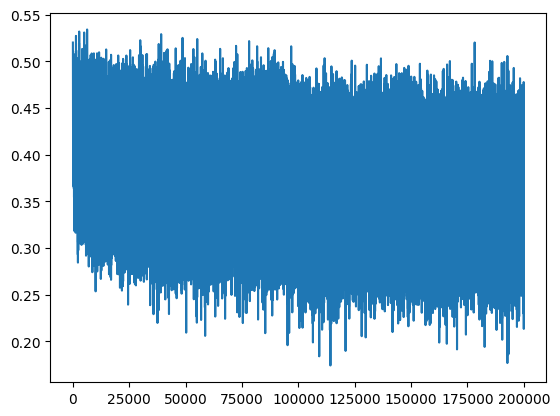

In [9]:
plt.plot(lossi);

In [12]:
@torch.no_grad() # will not call .grad on it, so under the hood doesn't need to be maintained (basically for efficieny)
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte)
    }[split]
    emb = C[x]
    embcat =emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss("train")
split_loss("val")


train 2.277318000793457
val 2.394143581390381


In [13]:
g = torch.Generator().manual_seed(23456)
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

nxiusbikkhamlitmachigabwa.
soffptel.
shigar.
jok.
yerkwitch.
akhach.
foatoff.
koso.
thuppus.
tsuixlihlivarkovskosokhloishiffeng.
kosi.
cuinakhonegyac.
brovbavyettray.
hivfedni.
kuhahpampytgloveglona.
puc.
mucronkovov.
mmambra.
tek.
kubulandiguinasy.


In [14]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) # / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []


n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(23456)


C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)
]

with torch.no_grad():
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

        

47551


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])


In [ ]:
plt.figure(figsize=(20, 4));
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+f | std %.2f | grad:data ratio %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > .97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title("Activation Distribution");

In [ ]:
plt.figure(figsize=(20, 4));
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f | std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title("Gradient Distribution");

In [ ]:
plt.figure(figsize=(20, 4));
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(f'weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends);
plt.title("Weights Gradient Distribution");

In [ ]:
plt.figure(figsize=(20, 4));
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], "k")
plt.legend(legends);
